**Description**: Demonstrates that subsampling / replicating within each dataset is
important. Data comes from running
[`meta.py`](https://github.com/kddubey/pretrain-on-test/blob/main/analysis/meta.py).
(`cd` to `analysis` before running `python meta.py`.)

**Estimated runtime**: ~5 sec.

In [1]:
from typing import Literal

import numpy as np
import polars as pl
import seaborn as sns

import matplotlib.pyplot as plt

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
num_test: Literal[200, 500] = 500
treatment, control = "test", "extra"
desc = "evaluation bias"
color = "orange"

In [4]:
df = pl.read_csv(f"meta_{num_test}_treatment.csv")

For the coin flip analogy:

In [5]:
magic_number = 0.04
df.select(
    (pl.col("mean") < -magic_number).or_(pl.col("mean") > magic_number)
).mean().item()

0.432

What percent of these are big differences have their 89% credible interval on one side
or the other?

In [6]:
df.filter((pl.col("mean") < -magic_number).or_(pl.col("mean") > magic_number)).select(
    (pl.col("hdi_5.5%") > 0).xor(pl.col("hdi_94.5%") > 0).not_()
).mean().item()

1.0

Perhaps it's more fair to say that roughly a quarter of findings would be significant
one way or the other. But I want the coin flip line :-]

In [7]:
title = (
    f"$\\mathbf{{No\:technical\:replication}}$, "
    f"$n={num_test}$, {desc}"
    # f"({utils.diffco_texa(treatment, control)})"
)

In [8]:
# plt.hist(df["mean"], bins=10, color=color)
# plt.title(title)
# plt.xlabel(f"posterior mean of $\\beta$")
# plt.ylabel("frequency");

In [9]:
# plt.plot(df["mean"].sort(), np.arange(1, len(df) + 1) / len(df), color=color)
# plt.title(title)
# plt.xlabel(f"posterior mean of $\\beta$")
# plt.ylabel("cumulative proportion");

In [10]:
means_sorted = df["mean"].sort().to_numpy()
y1, y2 = np.searchsorted(means_sorted, [-magic_number, magic_number]) / len(df)

In [11]:
xlim = (round(means_sorted[0], 2), round(means_sorted[-1], 2))

I want a CDF b/c it makes it easier to answer fun meta questions of the form: what's the
probability that we would've concluded < this wacky result > had we not subsampled?

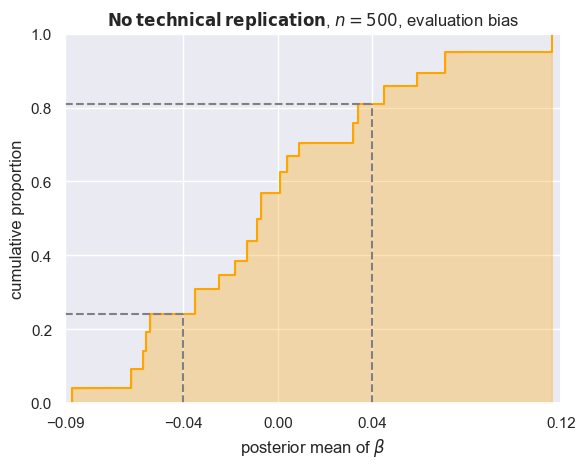

In [12]:
ax = sns.ecdfplot(df["mean"], color=color)
ax.set_xlim(xlim)
ax.set_xticks([xlim[0], -magic_number, 0, magic_number, xlim[1]])
_ = ax.set_title(title)
_ = ax.set_xlabel(f"posterior mean of $\\beta$")
_ = ax.set_ylabel("cumulative proportion")

# ty https://stackoverflow.com/a/47645844/18758987
_ = ax.fill_between(
    ax.lines[0].get_xydata()[:, 0],
    ax.lines[0].get_xydata()[:, 1],
    color=color,
    alpha=0.3,
)

ax.vlines(-magic_number, 0, y1, linestyle="dashed", color="gray")
ax.hlines(y1, xlim[0], -magic_number, linestyle="dashed", color="gray")

ax.vlines(magic_number, 0, y2, linestyle="dashed", color="gray")
ax.hlines(y2, xlim[0], magic_number, linestyle="dashed", color="gray");